In [79]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load
# +
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Lung Cancer Detection**

In [80]:
import pandas as pd

## Loading the Dataset

In [81]:
df_train = pd.read_csv("/kaggle/input/idealize-2025-datathon-competition/train.csv")
df_test = pd.read_csv("/kaggle/input/idealize-2025-datathon-competition/test.csv")

## Data exploration

In [82]:
df_train.isna().sum()

record_id                     0
first_name                    0
last_name                     0
sex                           0
patient_age                   0
residence_state               0
height_cm                     0
weight_kg                     0
smoking_status                0
cigarettes_per_day       499285
cholesterol_mg_dl             0
family_cancer_history         0
has_other_cancer              0
asthma_diagnosis              0
liver_condition               0
blood_pressure_status         0
diagnosis_date                0
cancer_stage                  0
treatment_start_date          0
treatment_type                0
treatment_end_date            0
survival_status               0
dtype: int64

In [83]:
df_test.isna().sum()

record_id                     0
first_name                    0
last_name                     0
sex                           0
patient_age                   0
residence_state               0
height_cm                     0
weight_kg                     0
smoking_status                0
cigarettes_per_day       125330
cholesterol_mg_dl             0
family_cancer_history         0
has_other_cancer              0
asthma_diagnosis              0
liver_condition               0
blood_pressure_status         0
diagnosis_date                0
cancer_stage                  0
treatment_start_date          0
treatment_type                0
treatment_end_date            0
dtype: int64

In [84]:
df_train.describe()

,record_id,patient_age,height_cm,weight_kg,cigarettes_per_day,cholesterol_mg_dl,cancer_stage,survival_status
count,999999.000000,999999.000000,999999.000000,999999.000000,500714.000000,999999.000000,999999.000000,999999.000000
mean,500000.000000,55.006108,168.486227,86.847382,10.000669,233.693956,2.498489,0.219604
std,288674.990255,10.000513,9.205421,25.791027,5.479090,43.394144,1.118590,0.413979
min,1.000000,8.000000,134.000000,32.000000,1.000000,150.000000,1.000000,0.000000
25%,250000.500000,48.000000,162.000000,65.000000,5.000000,197.000000,1.000000,0.000000
50%,500000.000000,55.000000,168.000000,86.000000,10.000000,242.000000,2.000000,0.000000
75%,749999.500000,62.000000,175.000000,106.000000,15.000000,271.000000,3.000000,0.000000
max,999999.000000,101.000000,206.000000,180.000000,19.000000,300.000000,4.000000,1.000000


In [85]:
df_test.describe()

,record_id,patient_age,height_cm,weight_kg,cigarettes_per_day,cholesterol_mg_dl,cancer_stage
count,2.500000e+05,250000.000000,250000.000000,250000.000000,124670.000000,250000.000000,250000.000000
mean,1.125000e+06,54.968628,168.518000,86.870576,10.000217,233.697692,2.497812
std,7.216893e+04,10.025659,9.230815,25.841215,5.476021,43.392722,1.117544
min,1.000000e+06,8.000000,136.000000,32.000000,1.000000,150.000000,1.000000
25%,1.062500e+06,48.000000,162.000000,65.000000,5.000000,197.000000,1.000000
50%,1.125000e+06,55.000000,168.000000,86.000000,10.000000,242.000000,2.000000
75%,1.187499e+06,62.000000,175.000000,106.000000,15.000000,271.000000,3.000000
max,1.249999e+06,99.000000,209.000000,180.000000,19.000000,300.000000,4.000000


In [86]:
# Survived to Not Survived Ratio
survived = df_train['survival_status'].value_counts()[1]
not_survived = df_train['survival_status'].value_counts()[0]

survived_ratio = survived/df_train.shape[0]
not_survived_ratio =  not_survived/df_train.shape[0]

print(f"Survived ratio : {survived_ratio} \nNot survived ratio : {not_survived_ratio}")

Survived ratio : 0.2196042196042196 
Not survived ratio : 0.7803957803957804


In [87]:
df_train['survival_status'].value_counts()

survival_status
0    780395
1    219604
Name: count, dtype: int64

## Data Pre-processing
### Data preprocessing Steps
- Filling `cigarattes_per_day` 
- Columns to encode(Binary) : `family_cancer_history`, `has_other_cancer`, `asthma_diagnosis`, `liver_condition`, `blood_pressure_status`
- Columns to encode (OneHot) : `residence_state`, `smoking_status`, `treatment_type`

In [94]:
# Importing the necessory Libraries 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class ProcessSmoking(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
        # Current Smokers - no NaNs
        # Never Smoked - no NaNs
        # Former Smokers - no NaNs
        # Passive smokers - contain NaNs
    def transform(self,X):
        X.loc[X['smoking_status'].isin(['Never Smoked', 'Passive Smoker', 'Passive', 'Non Smoker']), 'cigarettes_per_day'] = 0
        return X
    

class ProcessCols(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        # Encode 'family_cancer_history': Yes → 1, No → 0
        X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
        
        # Encode 'has_other_cancer': Yes → 1, No → 0
        X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
        
        # Encode 'asthma_diagnosis': Yes → 1, No → 0
        X['asthma_diagnosis'] = X['asthma_diagnosis'].replace({'Yes': 1, 'No': 0})
        
        # Clean and encode 'blood_pressure_status'
        X['blood_pressure_status'] = X['blood_pressure_status'].replace({
            'High Blood Pressure': 1,
            'Elevated': 1,
            'Normal': 0,
            'Normal BP': 0  # Treating 'Normal' and 'Normal BP' as same
        })
        
        # Clean and encode 'liver_condition'
        X['liver_condition'] = X['liver_condition'].replace({
            'Normal': 0,
            'Normal Liver': 0,
            'Liver OK': 0,
            'No Issue': 0,
            'Has Cirrhosis': 1,
            'Cirrhos': 1  # Assuming typo or shorthand for cirrhosis
        })
        X['sex'] = X['sex'].replace({'Male': 1, 'Female': 0})
        X['smoking_status'] = X['smoking_status'].replace({
            'Current Smoker': 'Current',
            'Former Smoker': 'Former',
            'Passive Smoker': 'Passive',
            'Never Smoked': 'Never',
            'Passive': 'Passive',
            'Non Smoker': 'Never',
            'Former Smk': 'Former'
        })
        X['treatment_type'] = X['treatment_type'].replace({
            'Chemo': 'Chemotherapy',
            'Surg': 'Surgery',
            'Combo': 'Combined'
        })
        X = X.drop('residence_state', axis=1)
        
        return X

class EncodeCatCols(BaseEstimator, TransformerMixin):
    def __init__(self, columns=['smoking_status', 'treatment_type']):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        encoded = self.encoder.transform(X[self.columns])
        
        # Get column names from OneHotEncoder
        column_names = self.encoder.get_feature_names_out(self.columns)
        
        # Create DataFrame from encoded matrix
        encoded_df = pd.DataFrame(encoded, columns=column_names, index=X.index)
        # Drop original categorical columns and join encoded ones
        X = X.drop(columns=self.columns)
        X = pd.concat([X, encoded_df], axis=1)
        
        return X


class FormatDates(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X['treatment_start_date'] = pd.to_datetime(X['treatment_start_date'], errors='coerce')
        X['treatment_end_date'] = pd.to_datetime(X['treatment_end_date'], errors='coerce')
        X['diagnosis_date'] = pd.to_datetime(X['diagnosis_date'], errors='coerce')
        X['treatment_duration'] = (X['treatment_end_date'] - X['treatment_start_date']).dt.days
        X['diagnosis_to_treatment_delay'] = (X['treatment_start_date'] - X['diagnosis_date']).dt.days
        
        X = X.drop(['treatment_end_date', 'treatment_start_date', 'diagnosis_date'], axis=1)
        return X

class DropUnwantedCols(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self

    def transform(self,X):
        X = X.drop(['first_name', 'last_name', 'record_id'], axis=1)
        return X




# Building Data Pre-Processing pipeline
data_pipeline = Pipeline([
    ('process_smoking', ProcessSmoking()),
    ('process_columns', ProcessCols()),
    ('format_dates', FormatDates()),
    ('encode_categoricals', EncodeCatCols(columns=['smoking_status', 'treatment_type'])),
    ('drop_unwanted', DropUnwantedCols()),
    ('scaler', StandardScaler())  
])


## Separating Independent Variables (X) and Dependent Variable (y)


In [89]:
X = df_train.drop('survival_status', axis=1)
y = df_train['survival_status']

## Pre-processing data 

In [90]:
X_transformed = data_pipeline.fit_transform(X)

/tmp/ipykernel_35/1862899771.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35/1862899771.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35/1862899771.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=F

In [91]:
X_test_transformed = data_pipeline.transform(df_test)

/tmp/ipykernel_35/1862899771.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['family_cancer_history'] = X['family_cancer_history'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35/1862899771.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['has_other_cancer'] = X['has_other_cancer'].replace({'Yes': 1, 'No': 0})
/tmp/ipykernel_35/1862899771.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=F

## Model Building

In [92]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight
import numpy as np

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# 2. Scale features
# -- done --

# 3. Compute class weights
weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
print("Class Weights:", class_weights)

# 4. Define the neural network with dropout
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output
])

# 5. Compile with additional metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(name='precision'),
                  tf.keras.metrics.Recall(name='recall'),
                  tf.keras.metrics.AUC(name='auc')
              ])

# 6. Early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 7. Train the model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=5,
                    batch_size=64,
                    class_weight=class_weights,
                    callbacks=[early_stop],
                    verbose=1)

# 8. Evaluate
loss, acc, prec, rec, auc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | AUC: {auc:.4f}")

# 9. Predictions
y_pred = (model.predict(X_test) > 0.49).astype("int32")

# 10. Full classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))


Class Weights: {0: 0.6406552309564995, 1: 2.2773956809136924}
Epoch 1/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.4969 - auc: 0.4997 - loss: 0.6954 - precision: 0.2198 - recall: 0.5048 - val_accuracy: 0.7557 - val_auc: 0.5057 - val_loss: 0.6900 - val_precision: 0.2203 - val_recall: 0.0447
Epoch 2/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.4651 - auc: 0.4994 - loss: 0.6937 - precision: 0.2198 - recall: 0.5627 - val_accuracy: 0.6056 - val_auc: 0.5008 - val_loss: 0.6953 - val_precision: 0.2224 - val_recall: 0.3196
Epoch 3/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.5098 - auc: 0.5019 - loss: 0.6937 - precision: 0.2208 - recall: 0.4862 - val_accuracy: 0.2195 - val_auc: 0.4992 - val_loss: 0.6973 - val_precision: 0.2194 - val_recall: 0.9999
Epoch 4/5
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.4535 - auc: 0.4991 - loss: 0.6936 - precision: 0.2196 - recall: 0.5821 - val_accuracy: 0.7806 - val_auc: 0.4999 - val_loss: 0.6905

In [95]:
df_test_transformed_scaled = data_pipeline.transform(df_test_transformed)

KeyError: 'smoking_status'

In [ ]:
df_test_transformed_scaled


In [ ]:
y_pred_prob = (model.predict(df_test_transformed_scaled)).flatten()


In [ ]:
y_pred_prob


* 0.498501 - 33.1%
* 0.4984 - 33.9%
* 0.4982 - 35%
* 0.498 - 35.3%
* 0.493 - 35.7%
* 0.49 - 35.8%



In [ ]:
y_pred = (y_pred_prob > 0.49).astype("int32") 

import numpy as np
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

In [ ]:
submission = pd.DataFrame({
    'record_id' : df_test['record_id'], 
    'survival_status' : y_pred.flatten()
})

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
submission['survival_status'].value_counts()

## Model Exporting 

In [68]:
import joblib
model.save('cancer_prediction_model.h5')
joblib.dump(data_pipeline, 'data_pipeline.pkl')



['data_pipeline.pkl']

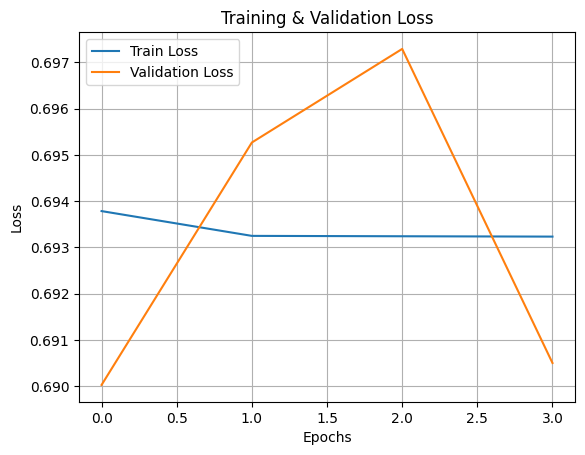

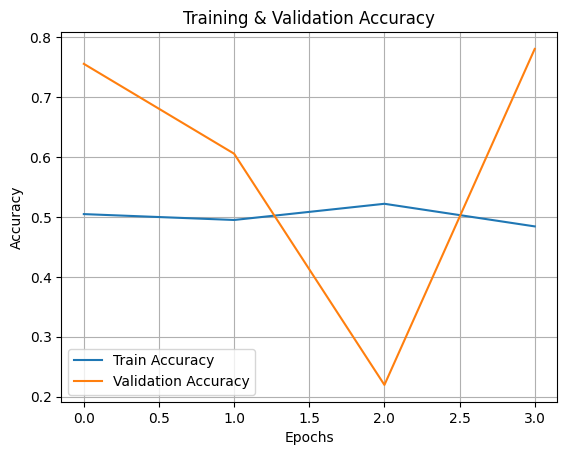

In [96]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
